## Information Entropy _ Decision Tree

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import operator
import json
from pylab import *

% matplotlib inline

In [2]:
data = pd.read_csv('watermelon3_0.csv')

D = np.array(data)

X = D[:, :-3]
y = D[:, -1].reshape([17,1])

dataSet = np.hstack((X, y)).tolist()

### Information entropy: $$Ent(D) = -\sum\limits_{k=1}^{|y|}p_klog_2p_k$$

### Information gain: $$Gain(D,a)=Ent(D)-\sum\limits_{v=1}^{V}\frac{|D^v|}{|D|}Ent(D^v)$$

In [6]:
def InformationEntropy(dataSet):
    Sample_Num = len(dataSet) ##count number of samples
    
    ## create a dict to record sample class and sample number of each class
    Sample_Class = {} 
    for datum in dataSet:
        Sample_Lablel = datum[-1]
        if Sample_Lablel not in Sample_Class.keys():
            Sample_Class[Sample_Lablel] = 1
        else:
            Sample_Class[Sample_Lablel] += 1
    
    ## calculate information entropy
    Ent_D = 0
    for key in Sample_Class:
        p_k = Sample_Class[key] / Sample_Num
        Ent_D -= p_k*np.log2(p_k)
        
#     for j in range(len(data[0]) - 1):
#         dataset.T[j]
        
    return Sample_Class, Ent_D

In [7]:
## split dataset by attribute return subset of input attribute value
def splitDataSet(dataSet, attri_index, attri_value):
    retDataSet = []
    featVec = []
    for featVec in dataSet:
        if featVec[attri_index] == attri_value:
#             print(featVec)
            reducedFeatVec = featVec[:attri_index]
#             print(reducedFeatVec)
            reducedFeatVec += featVec[attri_index + 1:]
#             print(b)
            retDataSet.append(reducedFeatVec)
    return retDataSet

In [8]:
## calculate optimal information Gain and choose optimal subset split mode
def optimal_attributeIndex(dataSet):
    ## get the attribute
    attribute_Num = len(dataSet[0]) - 1
    datasetInfEnt_D = InformationEntropy(dataSet)[-1]
    
    ## initialization
    optimal_InfGain_Da = 0
    optimal_attribute = -1
    
    ## calculate each attribute's information gain
    for i in range(attribute_Num):
        data_attribute = [data_attri[i] for data_attri in dataSet]
        data_values = set(data_attribute)
        attributeEntropy = 0
        for value in data_values:
            subDataSet = splitDataSet(dataSet, i, value)
            p_k = len(subDataSet) / float(len(dataSet))
            attributeEntropy += p_k * InformationEntropy(subDataSet)[-1]
        InfGain_Da = datasetInfEnt_D - attributeEntropy
#         print(InfGain_Da)
        if (InfGain_Da > optimal_InfGain_Da): ## choose optimal attribute
            optimal_InfGain_Da = InfGain_Da
            optimal_attribute = i
            
    return optimal_attribute

###### If the current node just have one attribute value, but the sample classes are different, set the current node as leaf node, and set the major sample class as its class.

In [9]:
## return the major sample class by sorting
def majorSampleClass(ClassList):
    ClassCount = {}
    for datum in ClassList:
#         print(datum)
        if datum not in ClassCount.keys():
            ClassCount[datum] = 1
        else:
            ClassCount[datum] += 1
    sortedClassCount = sorted(ClassCount.items(), key = operator.itemgetter(1), reverse = True)
    
    return sortedClassCount[0][0]

In [10]:
## define decision tree recursive function
def DecisionTreeRecursive(dataSet, attributes):
    ClassList = [datum[-1] for datum in dataSet]
    if ClassList.count(ClassList[0]) == len(ClassList): ## if there is only one class, return, else return major class
        return ClassList[0]
    if len(dataSet[0]) == 1:
        return majorSampleClass(ClassList)
    optimal_attri = optimal_attributeIndex(dataSet) ## get index of optimal attribute 
    optimal_attriLabel = attributes[optimal_attri]
    Deci_Tree = {optimal_attriLabel:{}}
    del (attributes[optimal_attri]) ## delete attribute already chosen
    attributeValues = [datum[optimal_attri] for datum in dataSet]
    for value in attributeValues:
        subLabels = attributes[:]
        Deci_Tree[optimal_attriLabel][value] = DecisionTreeRecursive(
            splitDataSet(dataSet, optimal_attri, value), subLabels)
        
    return Deci_Tree

In [11]:
attributes = data.columns[:-3].tolist()

In [12]:
DecisionTree = DecisionTreeRecursive(dataSet, attributes)

## plot decision tree

In [64]:
## set the shape and style of decision nodes, leaf nodes and arrows
DeciNode = dict(boxstyle = 'square, pad = 0.5', fc = '0.8')
LeafNode = dict(boxstyle = 'round4, pad = 0.5', fc = '0.8')
arrow_args = dict(arrowstyle = '<|-', connectionstyle="arc3", shrinkA=0,
                  shrinkB=16)
mpl.rcParams['font.sans-serif'] = ['SimHei']

In [95]:
def plotNode(Nodename, cenCoor, priorCoor, nodeType):  
    '''
    centerCoor: Node center coordinates
    priorPt: Starting point coordinates
    '''
    createFig.ax1.annotate(Nodename, xy = priorCoor, 
                            xycoords = 'axes fraction', xytext = cenCoor, 
                            textcoords = 'axes fraction', va = 'center', 
                            ha = 'center', bbox = nodeType, arrowprops = arrow_args)## plot charaters

##### We need to know the number of leaf nodes in order to determine the length of the X axis and the height of Y axis, and the floor number of decision tree.

In [15]:
def getLeafNum(Deci_Tree):
    '''
    Deci_Tree: dict, get by function DecisionTreeRecursive
    return number of leaf nodes
    '''
    
    ## initialization
    Leaf_Num = 0
    ## get the decision node
    RootNode = list(Deci_Tree.keys())[0] ## get root node
    BranchNodedict = Deci_Tree[RootNode] ## get the values of root node
    for key in BranchNodedict.keys():
        if type(BranchNodedict[key]).__name__ == 'dict': ## Determine whether the value is still a dictionary
            Leaf_Num += getLeafNum(BranchNodedict[key])
        else:
            Leaf_Num += 1
    
    return Leaf_Num

In [101]:
def getFloorNum(Deci_Tree):
    
    ## initialization
    maxFloor = 0    
#     currentFloor = 0
    RootNode = list(Deci_Tree.keys())[0] ## get root node
    BranchNodedict = Deci_Tree[RootNode] ## get the values of root node
    for key in BranchNodedict.keys():
        if type(BranchNodedict[key]).__name__ == 'dict': ## Determine whether the value is still a dictionary
            currentFloor = 1 + getFloorNum(BranchNodedict[key])
        else:
            currentFloor = 1
#             Leaf_Num = 1
        
        if currentFloor > maxFloor:
            maxFloor = currentFloor
            
    return maxFloor

In [102]:
## define plot text function
def plotText(cenCoor, priorCoor, txtString):
    txt_x = (priorCoor[0] + cenCoor[0]) / 2.0 # (priorCoor[0] - cenCoor[0]) / 2.0 + cenCoor[0] #
    txt_y = (priorCoor[1] + cenCoor[1]) / 2.0 # (priorCoor[1] - cenCoor[1]) / 2.0 + cenCoor[1] #
    createFig.ax1.text(txt_x, txt_y, txtString)

In [103]:
def plotTree(Deci_Tree, priorCoor, nodeName):
    LeafNum = getLeafNum(Deci_Tree)
    Floor = getFloorNum(Deci_Tree)
    RootNode = list(Deci_Tree.keys())[0]
    cenCoor = (plotTree.xoff + (1.0 + float(LeafNum)) / 2.0 / plotTree.totalw,
              plotTree.yoff)
    plotText(cenCoor, priorCoor, nodeName)
    plotNode(RootNode, cenCoor, priorCoor, DeciNode)
    BranchNodeDict = Deci_Tree[RootNode]
    plotTree.yoff = plotTree.yoff - 1.0 / plotTree.totalh
    for key in BranchNodeDict.keys():
        if type(BranchNodeDict[key]).__name__ == 'dict':
            plotTree(BranchNodeDict[key], cenCoor, str(key))
        else:
            plotTree.xoff = plotTree.xoff + 1.0 / plotTree.totalw
            plotNode(BranchNodeDict[key], (plotTree.xoff, plotTree.yoff), 
                     cenCoor, LeafNode)
            plotText((plotTree.xoff, plotTree.yoff), cenCoor, str(key))
    plotTree.yoff = plotTree.yoff + 1.0 / plotTree.totalh

In [104]:
def createFig(DecisionTree):
    fig = plt.figure(1, facecolor = 'white')
    fig.clf() ## clear figure plot area
    axprops = dict(xticks = [], yticks = [])
    createFig.ax1 = plt.subplot(111, frameon = False, **axprops)
    plotTree.totalw = float(getLeafNum(DecisionTree))
    plotTree.totalh = float(getFloorNum(DecisionTree))
    plotTree.xoff = -0.5 / plotTree.totalw
    plotTree.yoff = 1.0
    plotTree(DecisionTree, (0.5, 1.0), '')
#     plt.savefig('DecisionTree.jpg')
    plt.show()

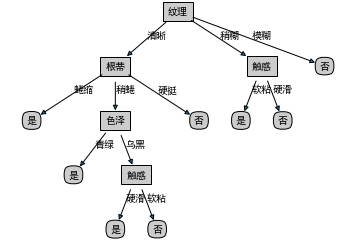

In [105]:
createFig(DecisionTree)